# Задача скоринга

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.weightstats import _tconfint_generic
from scipy import stats
import scipy

Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

- LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
- SEX: пол клиента (1 = мужской, 2 = женский )
- EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
- MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
- AGE: возраст в годах
- PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
- BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
- PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
- default - индикатор невозврата денежных средств

Импортируем данные и посмотрим на них

In [2]:
data=pd.read_csv('credit_card_default_analysis.csv')

In [3]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
data.shape

(30000, 25)

In [5]:
(data.dropna()).shape

(30000, 25)

Пропущенных значенией нет

# Задание 1
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

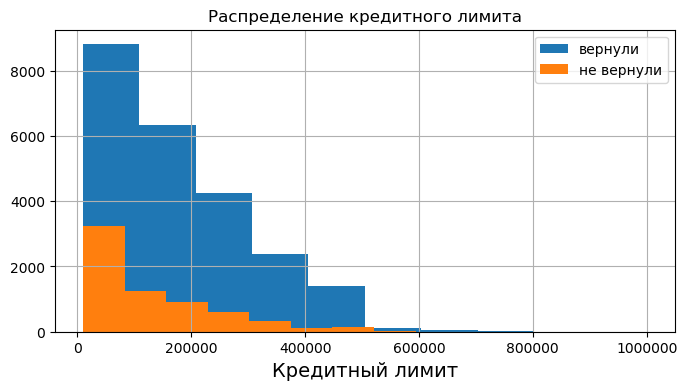

In [6]:
plt.figure(figsize=(8,4),dpi=100)
plt.title(u'Распределение кредитного лимита')
data.LIMIT_BAL[data.default==0].hist(label=u'вернули')
data.LIMIT_BAL[data.default==1].hist(label=u'не вернули')
plt.legend()
plt.xlabel(u'Кредитный лимит', fontsize=14)
plt.show()

In [7]:
m1 = data.LIMIT_BAL[data.default==0].median()
m2 = data.LIMIT_BAL[data.default==1].median()
print 'Median of LIMIT_BAL for returned credit:', m1
print 'Median of LIMIT_BAL for unreturned credit:', m2

Median of LIMIT_BAL for returned credit: 150000.0
Median of LIMIT_BAL for unreturned credit: 90000.0


Проверим гипотизу о равенстве медианных значений кредитного лимита при помощи bootstrap доверительных интервалов.

$H_0:$ медианы равны

$H_1:$ медианы неравны (двухсторнняя альтернатива)

In [8]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [9]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [10]:
no_default_LB = data.LIMIT_BAL[data.default==0].values
default_LB = data.LIMIT_BAL[data.default==1].values

no_default_median_scores = map(np.median, get_bootstrap_samples(no_default_LB, 10000))
default_median_scores = map(np.median, get_bootstrap_samples(default_LB, 10000))

print "95% confidence interval for the returned median credit limit:",  stat_intervals(no_default_median_scores, 0.05)
print "95% confidence interval for the unreturned median credit limit:",  stat_intervals(default_median_scores, 0.05)

95% confidence interval for the returned median credit limit: [150000. 150000.]
95% confidence interval for the unreturned median credit limit: [80000. 90000.]


Доверительные интервалы не пересекаются, следовательно, медианы размеров кредитного лимита для возвратных и невозвратных кредитов неравны.

Проверим гипотезу о равенстве распределений с помощью перестановочного критерия.

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

Двухсторонняя альтернатива.

In [11]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [12]:
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [13]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [14]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [15]:
print "p-value: {}".format(permutation_test(data.LIMIT_BAL[data.default==0],data.LIMIT_BAL[data.default==1], max_permutations = 10000))

p-value: 0.0001


Перестановочный тест дает достигаемый уровень значимости меньше 0.05. На уровне значимости 0.05 нулевая гипотеза о равенстве распределений отвергается, то есть распределения неодинаковы. С практической точки зрения разница в медианах кредитных лимитов значима. Для заемщиков допустивших дефолт медиана кредитного лимита меньше, что говорит о том, что банк имеет аппетит к риску и все-таки дает деньги сомнительным заемщикам, но при этом снижает риски за счет снижения кредитного лимита.

# Задание 2
Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

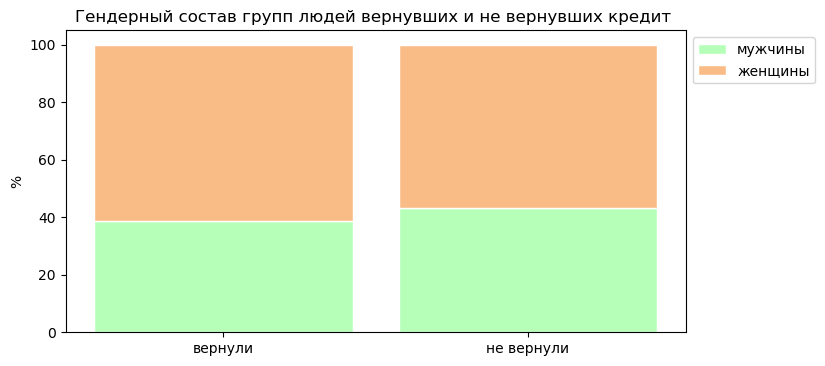

In [16]:
r = [0,1]
raw_data = {'men': np.bincount(data.default[data.SEX==1]), 'women': np.bincount(data.default[data.SEX==2])}
df = pd.DataFrame(raw_data,index=(u'венули',u'не вернули'))

totals = [i+j for i,j in zip(df['men'],  df['women'])]
greenBars = [i /float(j) * 100 for i,j in zip(df['men'], totals)]
orangeBars = [i /float(j) * 100 for i,j in zip(df['women'], totals)]
plt.figure(figsize=(8,4),dpi=100)
plt.title(u'Гендерный состав групп людей вернувших и не вернувших кредит ') 

barWidth = 0.85
names = (u'вернули',u'не вернули')
plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth,label=u'мужчины')
plt.bar(r, orangeBars, bottom=greenBars, color='#f9bc86', edgecolor='white', width=barWidth, label=u'женщины')

plt.xticks(r, names)
plt.ylabel("%")
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.show()

In [17]:
print u'Таблица сопряженности'
df

Таблица сопряженности


,men,women
венули,9015,14349
не вернули,2873,3763


### Доверительный интервал
Сравним долю мужчин в группах людей вернувших и не вернувших кредит. Для этого построим доверительный интервал для разности долей (независимые выборки). 

In [18]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

Функция принимает на вход два массива состоящих из 0 и 1. Запишем два вектора (sample0 - для вернувших кредит, sample1 - для невернувших) так, что значение элемента вектора равное 0 будет соответствовать женщине, а 1 - мужчине.

In [19]:
sample0=[]
for item in data.SEX[data.default==0]:
    if item==1: sample0.append(1)
    else:sample0.append(0)
sample1=[]
for item in data.SEX[data.default==1]:
    if item==1: sample1.append(1)
    else:sample1.append(0)

In [20]:
print "confidence interval: [%f, %f]" %proportions_confint_diff_ind( sample1, sample0,alpha = 0.05)

confidence interval: [0.033635, 0.060548]


Ноль не попадает в доверительный интервал. Можно сделать вывод, что гендерный состав групп людей вернувших и невернувших кредит неодинаков.

### Найдем  Z-критерий для разности долей (независимые выборки) 

Выборки измерены на разных объектах и взяты из распределения Бернулли (в выборке присутствует только 2 значения). 

$H_0:$ соотношение мужчин и женщин в группах вернувших и невернувших кредит равны

$H_1:$ соотношение мужчин и женщин в группах вернувших и невернувших кредит неравны

Двухсторонняя альтернатива.

In [21]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [22]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [23]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [24]:
print "p-value: ", proportions_diff_z_test(proportions_diff_z_stat_ind(sample1, sample0))

p-value:  4.472866521609831e-12


Z-критерий для разности долей отвернает нулевую гипотезу об одинаковом гендерном составе в группах вернувших и не вернувших кредит на уровне значимости 0.05.

# Задание 3
Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

In [25]:
def label_barh(bars, text_format, is_inside=True, **kwargs):
    """
    Attach a text label to each horizontal bar displaying its y value
    """
    max_y_value = max(bar.get_height() for bar in bars)
    if is_inside:
        distance = max_y_value * 20
    else:
        distance = max_y_value * 0.01


    for bar in bars:
        text = text_format.format(bar.get_width()/100.)
        if is_inside:
            text_x = bar.get_width() - distance
        else:
            text_x = bar.get_width() + distance
        text_y = bar.get_y() + bar.get_height() / 2

        plt.text(text_x, text_y, text, va='center', **kwargs)

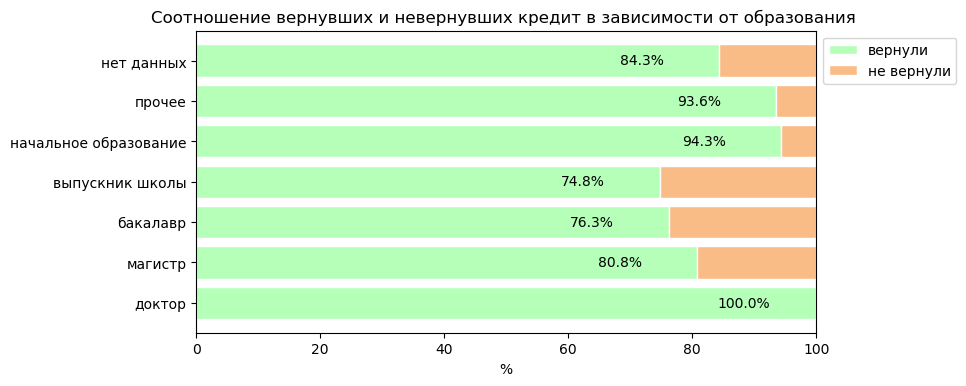

In [26]:
r = range(7)
raw_data = {'default0': np.bincount(data.EDUCATION[data.default==0]), 'default1': np.bincount(data.EDUCATION[data.default==1])}
df = pd.DataFrame(raw_data)

totals = [i+j for i,j in zip(df['default0'],  df['default1'])]
greenBars = [i /float(j) * 100 for i,j in zip(df['default0'], totals)]
orangeBars = [i /float(j) * 100 for i,j in zip(df['default1'], totals)]
plt.figure(figsize=(8,4),dpi=100)
plt.title(u'Соотношение вернувших и невернувших кредит в зависимости от образования ') 

names = (u'доктор',u'магистр',u'бакалавр', u'выпускник школы',u'начальное образование',u'прочее', u'нет данных')
bar1 = plt.barh(r, greenBars, color='#b5ffb9', edgecolor='white', label=u'вернули')
bar2 = plt.barh(r, orangeBars, left=greenBars, color='#f9bc86', edgecolor='white', label=u'не вернули')

plt.yticks(r, names)
plt.xlabel("%")
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
value_format = "{:.1%}"
label_barh(bar1, value_format, is_inside=True)

plt.show()

Отображение данных в процентном соотношение позволяет наглядно показать зависимость вероятности возврата кредита от уровня образования. Из гистограммы выше видно, что 100% докторов вернули кредит. С наименьшей вероятностью (примерно 75%) кредиты возвращают выпускники школ.

In [24]:
observed_frequences = np.vstack((np.bincount(data.EDUCATION[data.default==1]),np.bincount(data.EDUCATION[data.default==0])))
observed_frequences

array([[    0,  2036,  3330,  1237,     7,    18,     8],
       [   14,  8549, 10700,  3680,   116,   262,    43]])

Размер выборки > 40 и в каждом бине больше 5 элементов больше чем в 20% бинов. Можно использовать критерий хи-квадрат.

In [25]:
expected_frequences = stats.chi2_contingency(observed_frequences)[3]
print 'p-value = ',stats.chi2_contingency(observed_frequences)[1]

p-value =  1.2332626245415958e-32


$\chi^2$ тест показал, что между образованием и количеством дефолтов есть связь.

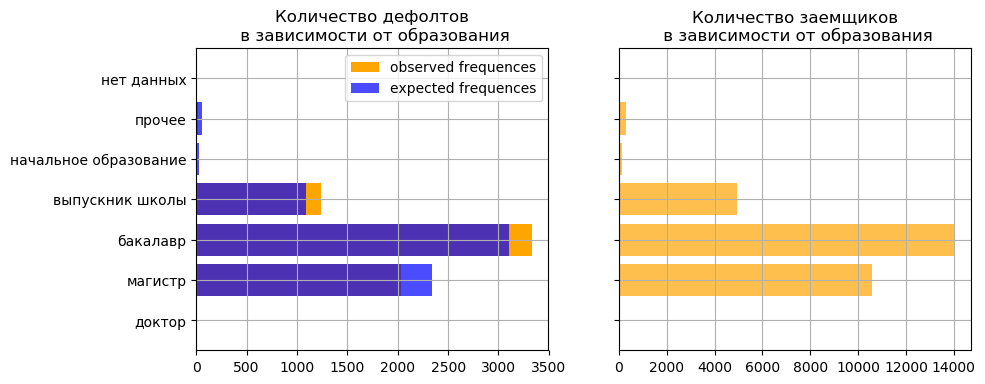

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,4),dpi=100)

ax1.set_title(u'Количество дефолтов\n в зависимости от образования')
ax1.barh(range(len(observed_frequences[0])), observed_frequences[0], color = 'orange', label = 'observed frequences')
ax1.barh(range(len(expected_frequences[0])), expected_frequences[0], color = 'b', label = 'expected frequences',alpha=0.7)
ax1.legend()
plt.yticks(r, names)
ax1.grid('on')

ax2.set_title(u'Количество заемщиков\n в зависимости от образования')
ax2.barh(range(len(np.bincount(data.EDUCATION))), np.bincount(data.EDUCATION), color = 'orange', label = 'observed frequences',alpha=0.7)
ax2.grid('on')

plt.show()

Из распределения заемщиков в зависимости от образования видно, что большинство заемщиков имеют образование бакалавра и как следствие количество дефолтов максимально среди бакалавров. 

Теперь посмотрим на разность между ожидаемыми и наблюдаемыми частотами дефолта.

In [29]:
pd.DataFrame(data=(observed_frequences - expected_frequences).T,index=names,columns=(u'не вернули',u'вернули')).sort_values(by=[u'не вернули'])

,не вернули,вернули
магистр,-305.4020,305.4020
прочее,-43.9360,43.9360
начальное образование,-20.2076,20.2076
нет данных,-3.2812,3.2812
доктор,-3.0968,3.0968
выпускник школы,149.3596,-149.3596
бакалавр,226.5640,-226.5640


Для групп "прочее", "начальное образование" и "нет данных" слишком мало данных, поэтому их можно не учитывать. 
Кроме того, нормируем разность ожидаемых и наблюдаемых частот на количество заемщиков с одинаковым образованием, чтобы сравнить их между собой.

In [30]:
df = pd.DataFrame(data=((observed_frequences - expected_frequences)/sum(observed_frequences)).T, 
                  index=names,columns=(u'не вернули',u'вернули'))
df.drop(index=[u'прочее',u'нет данных',u'начальное образование'])

,не вернули,вернули
доктор,-0.221200,0.221200
магистр,-0.028852,0.028852
бакалавр,0.016149,-0.016149
выпускник школы,0.030376,-0.030376


С ростом образования снижается риск дефолта. Из таблицы сопряженности видно, что чаще всего кредиты невозвращают выпускники школ, а наличие у заемщика докторской степени значительно снижает риск невозврата кредита.

# Задача 4
Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

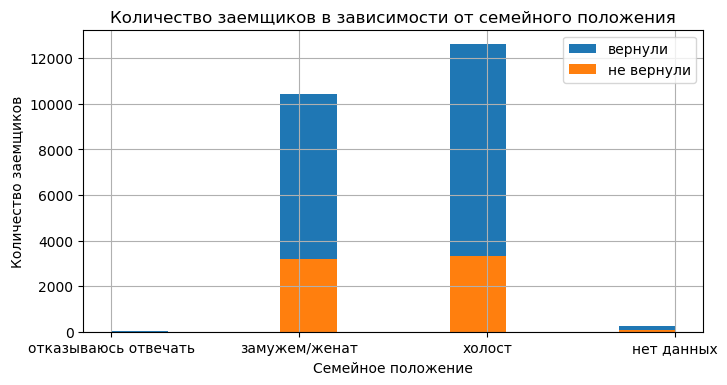

In [31]:
plt.figure(figsize=(8,4),dpi=100)
plt.title(u'Количество заемщиков в зависимости от семейного положения')
data.MARRIAGE[data.default==0].hist(label=u'вернули')
data.MARRIAGE[data.default==1].hist(label=u'не вернули')
plt.xlabel(u'Семейное положение')
plt.ylabel(u'Количество заемщиков')
names=[u'отказываюсь отвечать',u'замужем/женат',u'холост',u'нет данных']
plt.xticks(range(4), names)
plt.legend()
plt.show()

Мерой силы взаимосвязи между категориальными признаками служит коэффициент V Крамера. Для его вычисления нам потребуется статистика хи-квадрат.

Критерий хи-квадрат для таблиц сопряженности может применяться при выполнении следующих условий.
Нужно, чтобы выборки были достаточно большими: n > 40. Кроме того, необходимо, чтобы ожидаемое
количество элементов в каждой ячейке таблицы было меньше 5 $(\frac{n_{i+}+n_{+j}}{n} < 5)$, не более, чем в 20% ячеек.

In [17]:
observed_frequences = np.vstack((np.bincount(data.MARRIAGE[data.default==0]),np.bincount(data.MARRIAGE[data.default==1])))
observed_frequences

array([[   49, 10453, 12623,   239],
       [    5,  3206,  3341,    84]])

Все условия для применения критерия хи-квадрат выполняются.
Проверяем двухстороннюю альтернативу.

$H_0:$ Количество дефолтов независит от семейного положения.

$H_1:$ Количество дефолтов зависит от семейного положения.

In [18]:
expected_frequences = stats.chi2_contingency(observed_frequences)[3]
print 'p-value = ',stats.chi2_contingency(observed_frequences)[1]
chi2_stat = stats.chi2_contingency(observed_frequences)[0]

p-value =  8.825862457577375e-08


P-value < 0.05 => Количество дефолтов зависит от семейного положения.

In [23]:
Vc = np.sqrt(chi2_stat/data.shape[0])
print 'Vc =', Vc

Vc = 0.034478203662766466


Семейный статус и индикатор дефолта положительно коррелированы.

# Задание 5
Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

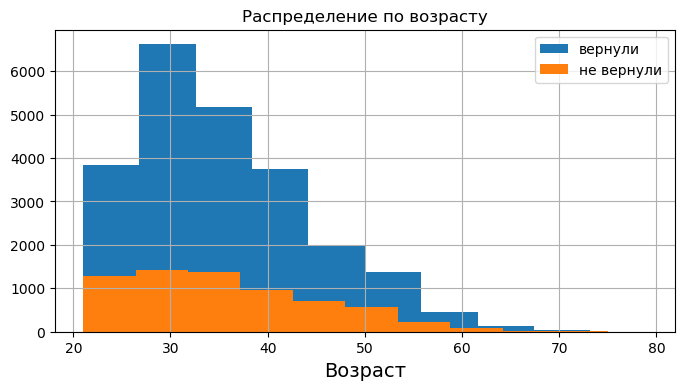

In [33]:
plt.figure(figsize=(8,4),dpi=100)
plt.title(u'Распределение по возрасту')
data.AGE[data.default==0].hist(label=u'вернули')
data.AGE[data.default==1].hist(label=u'не вернули')
plt.legend()
plt.xlabel(u'Возраст', fontsize=14)
plt.show()

In [34]:
m1 = data.AGE[data.default==0].median()
m2 = data.AGE[data.default==1].median()
print 'Age median for returned credit:', m1
print 'Age median for unreturned credit:', m2

Age median for returned credit: 34.0
Age median for unreturned credit: 34.0


In [35]:
no_default_AGE = data.AGE[data.default==0].values
default_AGE = data.AGE[data.default==1].values

no_default_median_scores = map(np.median, get_bootstrap_samples(no_default_AGE, 10000))
default_median_scores = map(np.median, get_bootstrap_samples(default_AGE, 10000))

print "95% confidence interval for median age of customer returned credit:",  stat_intervals(no_default_median_scores, 0.05)
print "95% confidence interval for median age of customer unreturned credit:",  stat_intervals(default_median_scores, 0.05)

95% confidence interval for median age of customer returned credit: [34. 34.]
95% confidence interval for median age of customer unreturned credit: [34. 35.]


Первый интервал является подмножеством второго интервала. Медианы совпадают.

Применим перестановочный критерий.

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

Двухсторонняя альтернатива.

In [36]:
print "p-value: {}".format(permutation_test(data.AGE[data.default==0],data.AGE[data.default==1], max_permutations = 10000))

p-value: 0.0186


Однако, перестановочный критерий отвергает гипотезу об одинаковых медианах на уровне значимости 0.05.

С практической точки знения отклонение в 1 год значения не имеет.